In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna
import joblib
from sklearn.metrics import make_scorer

/home/chico/Projetos/P5/PE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Dados/AmesHousing.csv")

df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


Feature engeniering básica

In [3]:
def add_age_features(df):
    df = df.copy()
    df["HouseAge"] = df["Yr Sold"] - df["Year Built"]
    df["RemodAge"] = df["Yr Sold"] - df["Year Remod/Add"]
    return df
age_transformer = FunctionTransformer(add_age_features)

In [4]:
TARGET = "SalePrice"

In [5]:
y = df[TARGET]
X = df.drop(columns=[TARGET])
print("Tamanho do dataset:", df.shape)
print("\nTipos de variáveis:\n", X.dtypes.value_counts())
#print("\nEstatísticas das variáveis numéricas:\n", X.describe().T)

Tamanho do dataset: (2930, 82)

Tipos de variáveis:
 object     43
int64      27
float64    11
Name: count, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [7]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numéricas:", len(num_cols), "Categoricas:", len(cat_cols))

Numéricas: 38 Categoricas: 43


Pré-processamento: pipelines

In [8]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

Função para avaliação


In [9]:
def evaluate_model(model, name):
    pipe = Pipeline([
        ('add_features', age_transformer),
        ('preproc', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")
    return {'Modelo': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'pipeline': pipe}

In [10]:
X_transformed = preprocessor.fit_transform(X)

# Número final de atributos
X_transformed.shape

(2930, 321)

In [11]:
results = []
results.append(evaluate_model(LinearRegression(), "Linear Regression"))
results.append(evaluate_model(Ridge(random_state=42), "Ridge"))
results.append(evaluate_model(Lasso(random_state=42, max_iter=10000), "Lasso"))
results.append(evaluate_model(RandomForestRegressor(random_state=42, n_jobs=-1), "Random Forest"))
results.append(evaluate_model(xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0), "XGBoost"))

baseline_df = pd.DataFrame(results)[['Modelo', 'RMSE', 'MAE', 'R2']]
print("\nDesempenho inicial:\n", baseline_df.sort_values('RMSE'))

Linear Regression -> RMSE: 848754906.356 | MAE: 15711.509 | R²: 0.894
Ridge -> RMSE: 827039588.997 | MAE: 16158.600 | R²: 0.897
Lasso -> RMSE: 841465188.969 | MAE: 15674.429 | R²: 0.895
Random Forest -> RMSE: 711477915.206 | MAE: 15906.563 | R²: 0.911
XGBoost -> RMSE: 685711360.000 | MAE: 15534.977 | R²: 0.914

Desempenho inicial:
               Modelo          RMSE           MAE        R2
4            XGBoost  6.857114e+08  15534.976562  0.914474
3      Random Forest  7.114779e+08  15906.562662  0.911260
1              Ridge  8.270396e+08  16158.600300  0.896846
2              Lasso  8.414652e+08  15674.428712  0.895047
0  Linear Regression  8.487549e+08  15711.508915  0.894138


Tuning com OPTUNA – Random Forest e XGBoost

RandomForestRegressor

In [12]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    pipe = Pipeline([('preproc', preprocessor), ('model', model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [13]:
study_rf = optuna.create_study(direction='minimize', study_name='rf_tuning')
study_rf.optimize(objective_rf, n_trials=40)
print("Melhores parâmetros RF:", study_rf.best_params)

[I 2025-11-07 18:53:31,537] A new study created in memory with name: rf_tuning


[I 2025-11-07 18:53:34,003] Trial 0 finished with value: 973899458.1730397 and parameters: {'n_estimators': 134, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 973899458.1730397.
[I 2025-11-07 18:53:51,642] Trial 1 finished with value: 746432243.5535408 and parameters: {'n_estimators': 230, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 746432243.5535408.
[I 2025-11-07 18:54:03,561] Trial 2 finished with value: 838304856.0154343 and parameters: {'n_estimators': 422, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 1 with value: 746432243.5535408.
[I 2025-11-07 18:54:31,583] Trial 3 finished with value: 739735167.477035 and parameters: {'n_estimators': 309, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 739735167.477035.
[I 2025-11-07 18:54:37,096] Trial 4 finished with value: 1394651663.539884 and parameters: {'n_estimator

Melhores parâmetros RF: {'n_estimators': 200, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [14]:
best_rf = Pipeline([
    ('preproc', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1, **study_rf.best_params))
])
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

XGBoost 

In [15]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)
    }
    model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, **params)
    pipe = Pipeline([('preproc', preprocessor), ('model', model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=make_scorer(mean_squared_error))
    return scores.mean()

In [16]:
study_xgb = optuna.create_study(direction='minimize', study_name='xgb_tuning')
study_xgb.optimize(objective_xgb, n_trials=40)
print("Melhores parâmetros XGB:", study_xgb.best_params)

[I 2025-11-07 19:06:41,706] A new study created in memory with name: xgb_tuning
[I 2025-11-07 19:06:46,927] Trial 0 finished with value: 617769228.8 and parameters: {'n_estimators': 312, 'max_depth': 6, 'learning_rate': 0.1024782915708922, 'subsample': 0.9810663715706478, 'colsample_bytree': 0.560453340501144, 'min_child_weight': 3, 'gamma': 0.7983290412136568, 'reg_lambda': 2.575280884885685, 'reg_alpha': 0.01981617359149857}. Best is trial 0 with value: 617769228.8.
[I 2025-11-07 19:06:49,430] Trial 1 finished with value: 638522540.8 and parameters: {'n_estimators': 206, 'max_depth': 4, 'learning_rate': 0.17540366952783812, 'subsample': 0.6935875274848018, 'colsample_bytree': 0.9502559986479946, 'min_child_weight': 2, 'gamma': 3.4077374126571875, 'reg_lambda': 8.807646330553716, 'reg_alpha': 0.20795425322030003}. Best is trial 0 with value: 617769228.8.
[I 2025-11-07 19:06:58,073] Trial 2 finished with value: 620453849.6 and parameters: {'n_estimators': 718, 'max_depth': 5, 'learning

Melhores parâmetros XGB: {'n_estimators': 349, 'max_depth': 8, 'learning_rate': 0.022165331011077073, 'subsample': 0.5753711146889513, 'colsample_bytree': 0.514401676518657, 'min_child_weight': 5, 'gamma': 4.293963399438284, 'reg_lambda': 0.10057128483956375, 'reg_alpha': 0.21031310036765433}


In [17]:
best_xgb = Pipeline([
    ('preproc', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, **study_xgb.best_params))
])
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

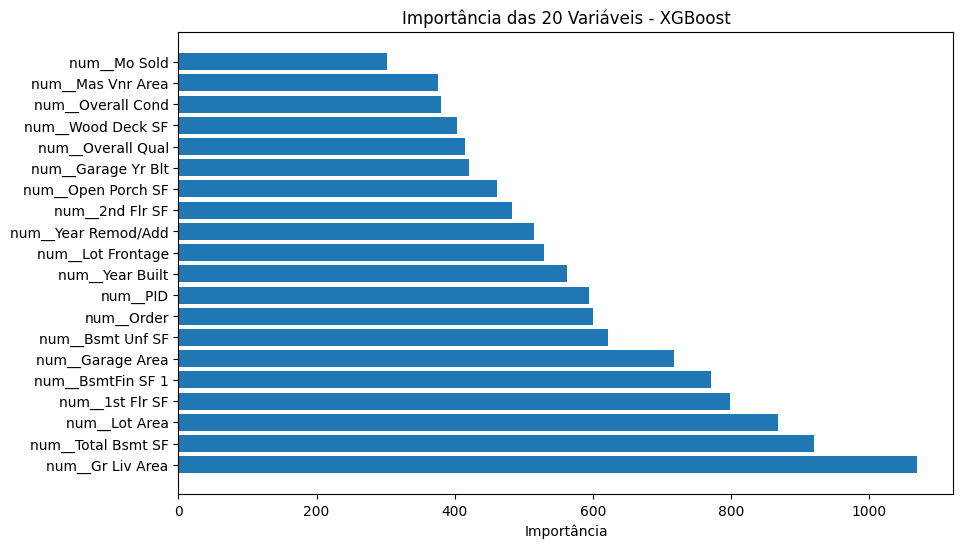

In [18]:
model_xgb = best_xgb.named_steps['model']
feature_names = best_xgb.named_steps['preproc'].get_feature_names_out()
importance = model_xgb.get_booster().get_score(importance_type='weight')

# Ordenar por importância (decrescente)
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)

top_n = 20
top_importance = importance_sorted[:top_n]

# Extraindo os nomes reais das variáveis
top_feature_names = [feature_names[int(item[0][1:])] for item in top_importance] 

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, [item[1] for item in top_importance])
plt.xlabel('Importância')
plt.title(f'Importância das {top_n} Variáveis - XGBoost')
plt.show()

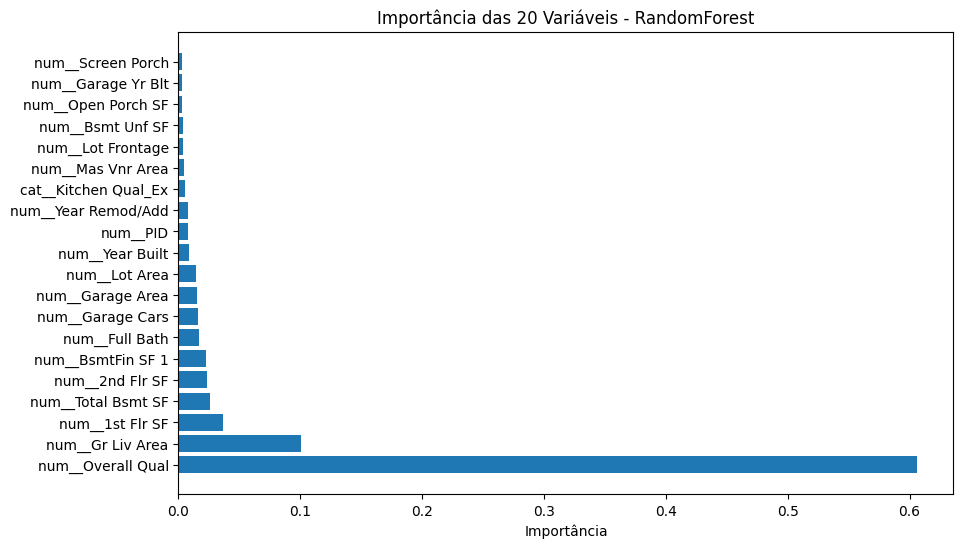

In [19]:
model_rf = best_rf.named_steps['model']
importances = model_rf.feature_importances_
preprocessor = best_rf.named_steps['preproc']
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

# Ordenar as variáveis por importância (decrescente)
indices = np.argsort(importances)[::-1]

# Selecionar as top 20 variáveis
top_n = 20
top_indices = indices[:top_n]
top_importance = importances[top_indices]
top_feature_names = feature_names[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_importance)
plt.xlabel('Importância')
plt.title(f'Importância das {top_n} Variáveis - RandomForest')
plt.show()

Resultados finais comparativos

In [20]:
final_df = pd.concat([
    baseline_df,
    pd.DataFrame([
        {'Modelo': 'RandomForest (Optuna)', 'RMSE': rf_rmse, 'MAE': rf_mae, 'R2': rf_r2},
        {'Modelo': 'XGBoost (Optuna)', 'RMSE': xgb_rmse, 'MAE': xgb_mae, 'R2': xgb_r2}
    ])
], ignore_index=True).sort_values('RMSE')
print("\nResultados finais comparativos:\n", final_df)


Resultados finais comparativos:
                   Modelo          RMSE           MAE        R2
6       XGBoost (Optuna)  5.458689e+08  13739.199219  0.931916
4                XGBoost  6.857114e+08  15534.976562  0.914474
3          Random Forest  7.114779e+08  15906.562662  0.911260
5  RandomForest (Optuna)  7.269033e+08  15879.706158  0.909336
1                  Ridge  8.270396e+08  16158.600300  0.896846
2                  Lasso  8.414652e+08  15674.428712  0.895047
0      Linear Regression  8.487549e+08  15711.508915  0.894138


Visualização e comparação

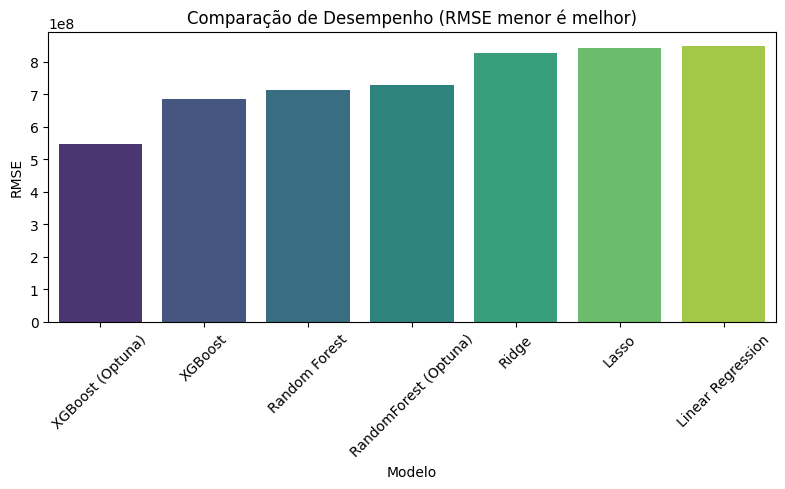

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(data=final_df, x='Modelo', y='RMSE', palette='viridis', hue='Modelo')
plt.xticks(rotation=45)
plt.title('Comparação de Desempenho (RMSE menor é melhor)')
plt.tight_layout()
plt.show()


Salvando artefatos

In [22]:
joblib.dump(best_rf, 'Resultados/best_random_forest_optuna.joblib')
joblib.dump(best_xgb, 'Resultados/best_xgboost_optuna.joblib')
final_df.to_csv('comparacao_modelos.csv', index=False)

print("\nModelos e resultados salvos com sucesso!")


Modelos e resultados salvos com sucesso!
